# GCC-PHAT Test Suite

## Overview
Systematic testing of GCC-PHAT TDoA estimation under varying conditions:
- **24 scenarios**: Fixed radius (3 km), varying TX angle (0° to 345° in 15° steps)
- **3 scenarios**: Fixed TX position (45°), varying sample rate (2 MHz, 3 MHz, 4 MHz)

## Test Configuration
- **Receiver Array**: 4-node square, 1 km baseline near Sumy, Ukraine
- **Signal Format**: 362 samples/packet × 1440 packets = 521,280 samples
- **Chirp Bandwidth**: 200 kHz
- **Speed of Light**: c = 299,792,458 m/s

## Metrics
- Localization error (meters): distance between true and estimated TX position
- TDoA estimation accuracy (microseconds)
- Processing time per scenario
- Error statistics by angle quadrant

## Visualizations
- Error vs TX angle (line plot)
- Error vs sample rate (line plot)
- Spatial map: true vs estimated TX positions with error vectors

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import time
import importlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

NOTEBOOK_DIR = Path.cwd()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
sys.path.insert(0, str(REPO_ROOT))

import src.core.gcc
import src.core.iq_handler
import src.core.tdoa
import src.core.utils
import src.core

importlib.reload(src.core.gcc)
importlib.reload(src.core.iq_handler)
importlib.reload(src.core.tdoa)
importlib.reload(src.core.utils)
importlib.reload(src.core)

from src.core import (
    generate_chirp,
    save_iq_file,
    write_metadata,
    load_iq_dataset,
    gcc_phat,
    solve_tdoa_pairwise,
    lonlat_to_xy_m,
    xy_m_to_lonlat,
)
from simulation.tdoa_sim import all_pairs

c = 299792458

print("Modules loaded successfully")

Modules loaded successfully


In [2]:
# Delay functions (from signal_gen_real notebook)
def _fractional_delay_fir(frac: float, num_taps: int) -> np.ndarray:
    """Design windowed-sinc fractional delay FIR."""
    if num_taps < 3:
        raise ValueError("num_taps must be >= 3")
    n = np.arange(num_taps, dtype=np.float64) - (num_taps - 1) / 2.0
    h = np.sinc(n - float(frac))
    h *= np.hamming(num_taps)
    h /= np.sum(h)
    return h

def apply_delay(x: np.ndarray, delay_samples: float, out_len: int, num_taps: int = 33) -> np.ndarray:
    """Apply fractional sample delay to signal."""
    if delay_samples < 0:
        raise ValueError("delay_samples must be >= 0")
    d_int = int(np.floor(delay_samples))
    frac = float(delay_samples - d_int)
    y = x.astype(np.complex64, copy=False)
    if frac > 1e-12:
        h = _fractional_delay_fir(frac, num_taps)
        y = np.convolve(y, h.astype(np.float32), mode="same").astype(np.complex64)
    out = np.zeros(int(out_len), dtype=np.complex64)
    start = d_int
    if start >= out_len:
        return out
    n_copy = min(out_len - start, y.size)
    out[start:start + n_copy] = y[:n_copy]
    return out

def toa_delay_samples(rx_lonlat: np.ndarray, tx_lonlat: np.ndarray, fs: float) -> np.ndarray:
    """Compute TOA delays in samples from TX to RX positions."""
    rx_xy = lonlat_to_xy_m(rx_lonlat)
    tx_xy = lonlat_to_xy_m(np.asarray(tx_lonlat, dtype=np.float64).reshape(1, 2))[0]
    dist_m = np.linalg.norm(rx_xy - tx_xy, axis=1)
    tau_s = dist_m / float(c)
    return tau_s * float(fs)

print("Helper functions defined")

Helper functions defined


In [3]:
# Fixed receiver configuration (4-node square, 1 km spacing near Sumy)
base_lon, base_lat = 34.8000, 50.9220
spacing_km = 1.0
deg_per_km_lat = 1.0 / 111.32
deg_per_km_lon = 1.0 / (111.32 * np.cos(np.deg2rad(base_lat)))

receivers = np.array([
    [base_lon + 0.0 * spacing_km * deg_per_km_lon, base_lat + 0.0 * spacing_km * deg_per_km_lat],
    [base_lon + 1.0 * spacing_km * deg_per_km_lon, base_lat + 0.0 * spacing_km * deg_per_km_lat],
    [base_lon + 1.0 * spacing_km * deg_per_km_lon, base_lat + 1.0 * spacing_km * deg_per_km_lat],
    [base_lon + 0.0 * spacing_km * deg_per_km_lon, base_lat + 1.0 * spacing_km * deg_per_km_lat],
], dtype=np.float64)

center_lon = base_lon + 0.5 * spacing_km * deg_per_km_lon
center_lat = base_lat + 0.5 * spacing_km * deg_per_km_lat

print(f"Receiver array configured: 4 nodes, {spacing_km} km baseline")
print(f"Center: ({center_lat:.6f}N, {center_lon:.6f}E)")

Receiver array configured: 4 nodes, 1.0 km baseline
Center: (50.926492N, 34.807125E)


In [4]:
def generate_scenario(tx_lonlat: np.ndarray, fs: float, scenario_name: str) -> dict:
    """Generate and process one test scenario.
    
    Returns:
        Dictionary with results: error_m, tdoa_estimates, processing_time_s
    """
    # Signal format metadata (describes SDR capture structure)
    n_samples_per_packet = 362
    n_packets = 1440
    total_capture_samples = n_samples_per_packet * n_packets  # 521,280 samples
    
    # Generate continuous chirp signal
    duration = total_capture_samples / fs
    bandwidth = 200_000.0
    chirp = generate_chirp(fs=fs, n_samples=total_capture_samples, bandwidth=bandwidth, phase=0.0)
    
    # Compute geometric delays
    d_abs = toa_delay_samples(receivers, tx_lonlat, fs)
    d_rel = d_abs - np.min(d_abs)
    
    # Generate delayed signals (buffer sized for signal + delays)
    max_delay = int(np.ceil(np.max(d_rel)))
    total_samples = total_capture_samples + max_delay + 1000
    rx_sigs = [apply_delay(chirp, float(d), out_len=total_samples, num_taps=33) for d in d_rel]
    
    # Save to temporary files
    temp_dir = NOTEBOOK_DIR / "data" / "temp" / scenario_name
    temp_dir.mkdir(parents=True, exist_ok=True)
    
    for rx_idx, signal in enumerate(rx_sigs):
        save_iq_file(temp_dir / f"{rx_idx}_RX.iq", signal)
    
    write_metadata(
        temp_dir / "metadata.txt",
        fs=fs,
        n_samples=362,
        n_packets=1440,
        receivers=receivers,
        tx_pos=tx_lonlat
    )
    
    # Load and process
    rx_signals, metadata = load_iq_dataset(temp_dir)
    
    # Compute TDoA with timing
    start_time = time.time()
    
    pairs = all_pairs(4)
    tdoa_measurements = {}
    
    for i, j in pairs:
        corr, lags = gcc_phat(rx_signals[i], rx_signals[j], fs)
        peak_idx = np.argmax(np.abs(corr))
        delay_samples = lags[peak_idx]
        tdoa_sec = delay_samples / fs
        tdoa_measurements[(i, j)] = tdoa_sec
    
    # Solve localization
    receivers_xy = lonlat_to_xy_m(receivers)
    tdoa_pairs = [(i, j, tdoa_measurements[(i, j)]) for i, j in pairs]
    tx_estimated_xy, result = solve_tdoa_pairwise(receivers_xy, tdoa_pairs, c=c)
    
    processing_time = time.time() - start_time
    
    # Compute error
    tx_true_xy = lonlat_to_xy_m(tx_lonlat)[0]
    error_m = np.linalg.norm(tx_estimated_xy - tx_true_xy)
    
    return {
        'error_m': error_m,
        'tdoa_estimates': tdoa_measurements,
        'processing_time_s': processing_time,
        'true_delays_us': d_rel / fs * 1e6,
        'fs': fs,
        'tx_lonlat': tx_lonlat,
        'tx_true_xy': tx_true_xy,
        'tx_estimated_xy': tx_estimated_xy
    }

print("Scenario generator function ready")

Scenario generator function ready


## Test Set 1: Varying TX Angle (Fixed Radius)

TX positioned at 3 km radius from center, 24 angles: 0° to 345° in 15° steps

In [5]:
# Test Set 1: Varying angle scenarios
radius_km = 3.0
angles_deg = np.arange(0, 360, 15)
fs_fixed = 2_000_000.0

results_angle = []

for angle in angles_deg:
    angle_rad = np.deg2rad(angle)
    tx_lon = center_lon + radius_km * np.cos(angle_rad) * deg_per_km_lon
    tx_lat = center_lat + radius_km * np.sin(angle_rad) * deg_per_km_lat
    tx_lonlat = np.array([tx_lon, tx_lat], dtype=np.float64)
    
    scenario_name = f"angle_{int(angle):03d}"
    print(f"\nProcessing scenario: {scenario_name} (TX at {angle}°, {radius_km} km radius)")
    
    result = generate_scenario(tx_lonlat, fs_fixed, scenario_name)
    result['angle_deg'] = angle
    result['radius_km'] = radius_km
    results_angle.append(result)
    
    print(f"  Error: {result['error_m']:.2f} m, Processing: {result['processing_time_s']:.3f} s")

print("\nAngle variation test complete")


Processing scenario: angle_000 (TX at 0°, 3.0 km radius)
  Error: 4759.03 m, Processing: 0.200 s

Processing scenario: angle_015 (TX at 15°, 3.0 km radius)
  Error: 4758.82 m, Processing: 0.193 s

Processing scenario: angle_030 (TX at 30°, 3.0 km radius)
  Error: 3643.41 m, Processing: 0.195 s

Processing scenario: angle_045 (TX at 45°, 3.0 km radius)
  Error: 7054515.34 m, Processing: 0.199 s

Processing scenario: angle_060 (TX at 60°, 3.0 km radius)
  Error: 3644.38 m, Processing: 0.201 s

Processing scenario: angle_075 (TX at 75°, 3.0 km radius)
  Error: 4760.41 m, Processing: 0.210 s

Processing scenario: angle_090 (TX at 90°, 3.0 km radius)
  Error: 4760.83 m, Processing: 0.209 s

Processing scenario: angle_105 (TX at 105°, 3.0 km radius)
  Error: 4760.41 m, Processing: 0.205 s

Processing scenario: angle_120 (TX at 120°, 3.0 km radius)
  Error: 3644.39 m, Processing: 0.210 s

Processing scenario: angle_135 (TX at 135°, 3.0 km radius)
  Error: 10192770.74 m, Processing: 0.200 s



## Test Set 2: Varying Sample Rate (Fixed Position)

TX at fixed position (45°, 3 km), sample rates: 2 MHz, 3 MHz, 4 MHz

In [6]:
# Test Set 2: Varying sample rate
fixed_angle = 45.0
fixed_angle_rad = np.deg2rad(fixed_angle)
tx_lon_fixed = center_lon + radius_km * np.cos(fixed_angle_rad) * deg_per_km_lon
tx_lat_fixed = center_lat + radius_km * np.sin(fixed_angle_rad) * deg_per_km_lat
tx_lonlat_fixed = np.array([tx_lon_fixed, tx_lat_fixed], dtype=np.float64)

sample_rates = [2_000_000.0, 3_000_000.0, 4_000_000.0]

results_fs = []

for fs in sample_rates:
    scenario_name = f"fs_{int(fs/1e6):d}MHz"
    print(f"\nProcessing scenario: {scenario_name} (fs = {fs/1e6:.1f} MHz)")
    
    result = generate_scenario(tx_lonlat_fixed, fs, scenario_name)
    results_fs.append(result)
    
    print(f"  Error: {result['error_m']:.2f} m, Processing: {result['processing_time_s']:.3f} s")

print("\nSample rate variation test complete")


Processing scenario: fs_2MHz (fs = 2.0 MHz)
  Error: 7054515.34 m, Processing: 0.191 s

Processing scenario: fs_3MHz (fs = 3.0 MHz)
  Error: 4759.32 m, Processing: 0.186 s

Processing scenario: fs_4MHz (fs = 4.0 MHz)
  Error: 637.26 m, Processing: 0.193 s

Sample rate variation test complete


## Results Analysis

In [7]:
# Summary table: Angle variation
df_angle = pd.DataFrame([
    {
        'Angle (deg)': r['angle_deg'],
        'Error (m)': r['error_m'],
        'Processing (s)': r['processing_time_s']
    }
    for r in results_angle
])

print("\n" + "="*60)
print("TEST SET 1: ANGLE VARIATION (3 km radius, 2 MHz)")
print("="*60)
print(df_angle.to_string(index=False))
print(f"\nMean error: {df_angle['Error (m)'].mean():.2f} m")
print(f"Std error: {df_angle['Error (m)'].std():.2f} m")
print(f"Max error: {df_angle['Error (m)'].max():.2f} m")


TEST SET 1: ANGLE VARIATION (3 km radius, 2 MHz)
 Angle (deg)    Error (m)  Processing (s)
           0 4.759029e+03        0.199500
          15 4.758820e+03        0.193410
          30 3.643409e+03        0.195005
          45 7.054515e+06        0.199317
          60 3.644380e+03        0.200635
          75 4.760410e+03        0.210280
          90 4.760830e+03        0.209265
         105 4.760410e+03        0.204619
         120 3.644387e+03        0.209871
         135 1.019277e+07        0.199666
         150 3.643421e+03        0.197978
         165 4.758820e+03        0.189593
         180 4.759029e+03        0.202044
         195 4.758792e+03        0.193344
         210 3.643137e+03        0.203086
         225 7.299517e+06        0.225901
         240 3.642519e+03        0.202679
         255 4.757999e+03        0.198202
         270 4.758149e+03        0.197970
         285 4.757999e+03        0.201475
         300 3.642686e+03        0.197030
         315 7.040022e+06 

In [8]:
# Summary table: Sample rate variation
df_fs = pd.DataFrame([
    {
        'Sample Rate (MHz)': r['fs'] / 1e6,
        'Error (m)': r['error_m'],
        'Processing (s)': r['processing_time_s']
    }
    for r in results_fs
])

print("\n" + "="*60)
print("TEST SET 2: SAMPLE RATE VARIATION (45° angle, 3 km radius)")
print("="*60)
print(df_fs.to_string(index=False))
print(f"\nMean error: {df_fs['Error (m)'].mean():.2f} m")


TEST SET 2: SAMPLE RATE VARIATION (45° angle, 3 km radius)
 Sample Rate (MHz)    Error (m)  Processing (s)
               2.0 7.054515e+06        0.190619
               3.0 4.759322e+03        0.186456
               4.0 6.372610e+02        0.192913

Mean error: 2353303.97 m


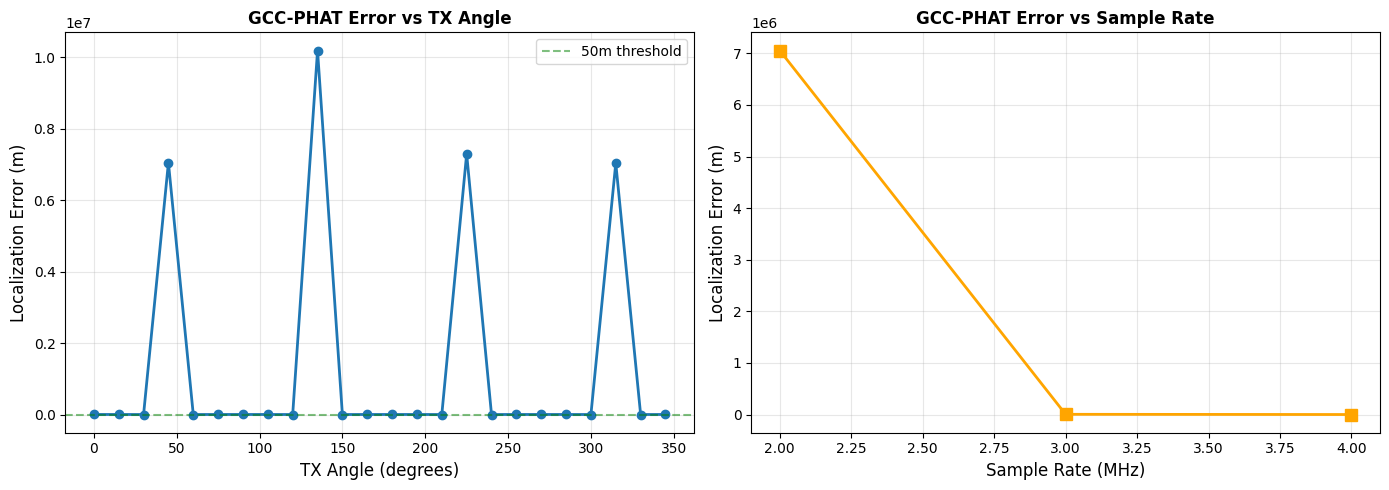

Visualization complete


In [9]:
# Visualization: Error vs Angle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

angles = [r['angle_deg'] for r in results_angle]
errors = [r['error_m'] for r in results_angle]

ax1.plot(angles, errors, 'o-', linewidth=2, markersize=6)
ax1.set_xlabel('TX Angle (degrees)', fontsize=12)
ax1.set_ylabel('Localization Error (m)', fontsize=12)
ax1.set_title('GCC-PHAT Error vs TX Angle', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(50, color='green', linestyle='--', alpha=0.5, label='50m threshold')
ax1.legend()

# Error vs Sample Rate
fs_vals = [r['fs'] / 1e6 for r in results_fs]
errors_fs = [r['error_m'] for r in results_fs]

ax2.plot(fs_vals, errors_fs, 's-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Sample Rate (MHz)', fontsize=12)
ax2.set_ylabel('Localization Error (m)', fontsize=12)
ax2.set_title('GCC-PHAT Error vs Sample Rate', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization complete")